<a href="https://colab.research.google.com/github/cristefarubio/EPIC_1/blob/main/Homework1_DataEPIC2_GroupMaterials1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **DATA**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyvista

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 15.2 MB/s 
     |████████████████████████████████| 79.3 MB 1.2 MB/s 


In [ ]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
input_directory="/content/drive/My Drive/Colab Notebooks/"
file_name = "turbulence_sub_hr.vtk"

In [ ]:
mesh = pv.read(input_directory+file_name)

print(mesh)

RectilinearGrid (0x7f2043e48c20)
  N Cells:	40000
  N Points:	40401
  X Bounds:	-2.000e+00, 2.000e+00
  Y Bounds:	-2.000e+00, 2.000e+00
  Z Bounds:	0.000e+00, 0.000e+00
  Dimensions:	201, 201, 1
  N Arrays:	5



In [ ]:
rho = pv.get_array(mesh, "rho", preference = 'cell') # density in code units
vx1 = pv.get_array(mesh, "vx1", preference = 'cell') # x velocity component in code units
vx2 = pv.get_array(mesh, "vx2", preference = 'cell') # y velocity component in code units
Bx1 = pv.get_array(mesh, "Bx1", preference = 'cell') # x magnetic field component in code units
Bx2 = pv.get_array(mesh, "Bx2", preference = 'cell') # y magnetic field component in code units

In [ ]:
rho_2D = rho.reshape(mesh.dimensions[0] - 1, mesh.dimensions[1] - 1)
vx1_2D = vx1.reshape(mesh.dimensions[0] - 1, mesh.dimensions[1] - 1)
vx2_2D = vx2.reshape(mesh.dimensions[0] - 1, mesh.dimensions[1] - 1)
Bx1_2D = Bx1.reshape(mesh.dimensions[0] - 1, mesh.dimensions[1] - 1)
Bx2_2D = Bx2.reshape(mesh.dimensions[0] - 1, mesh.dimensions[1] - 1)


In [ ]:
x = np.linspace(mesh.bounds[0], mesh.bounds[1], mesh.dimensions[0] - 1)
y = np.linspace(mesh.bounds[2], mesh.bounds[3], mesh.dimensions[1] - 1)

X, Y = np.meshgrid(x, y)

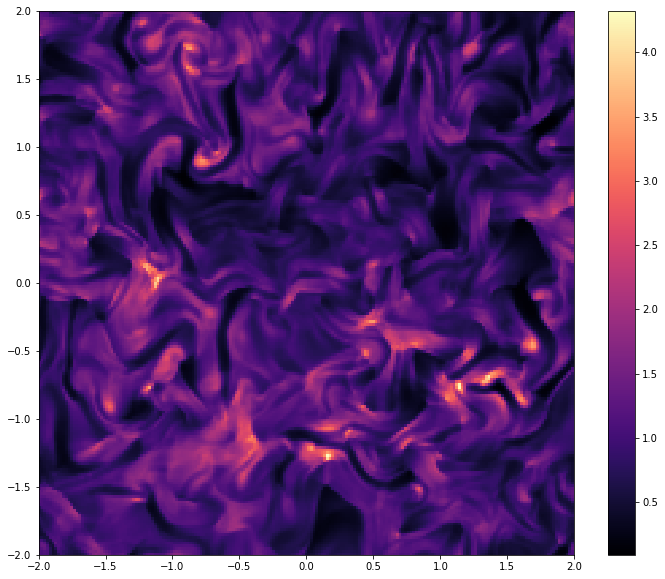

In [ ]:
plt.figure(figsize = (12,10))

Z = plt.pcolor(X, Y, rho_2D, cmap = 'magma')

plt.colorbar(Z)

plt.show()

## **TASK 1**


In [ ]:
m = np.linspace(mesh.bounds[0], mesh.bounds[1], mesh.dimensions[0] - 1)
n = np.linspace(mesh.bounds[2], mesh.bounds[3], mesh.dimensions[1] - 1)

ve= np.meshgrid(m, n)
for i in range(mesh.dimensions[0] - 1):
  ve[0][i] = vx1_2D[i]*vx1_2D[i] 
  ve[1][i] = vx2_2D[i]*vx2_2D[i]

ve2 = ve[0] + ve[1]
ki = (1/2)*rho_2D*ve2
print(ki)

[[0.19386749 0.14330217 0.29517324 ... 0.15839921 0.19030066 0.20850526]
 [0.27862619 0.24633175 0.42856913 ... 0.27110457 0.29138176 0.30036076]
 [0.46427565 0.43854345 0.52501593 ... 0.1864981  0.36030904 0.40962041]
 ...
 [0.21077822 0.14722496 0.19404924 ... 0.20083834 0.24013069 0.26169211]
 [0.1964361  0.12020525 0.19363068 ... 0.1300164  0.17056359 0.23008749]
 [0.19250162 0.12800974 0.22560519 ... 0.12144075 0.17324624 0.21663464]]


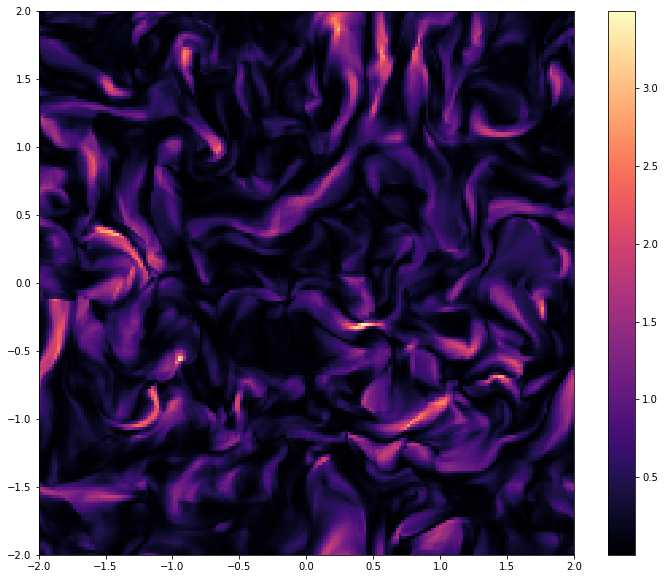

In [ ]:
plt.figure(figsize = (12,10))

Z = plt.pcolor(X, Y, ki, cmap = 'magma')

plt.colorbar(Z)

plt.show()

### **TASK 2**

In [ ]:
fourier_2D = np.fft.fft2(ki)
#print (fourier_2D)

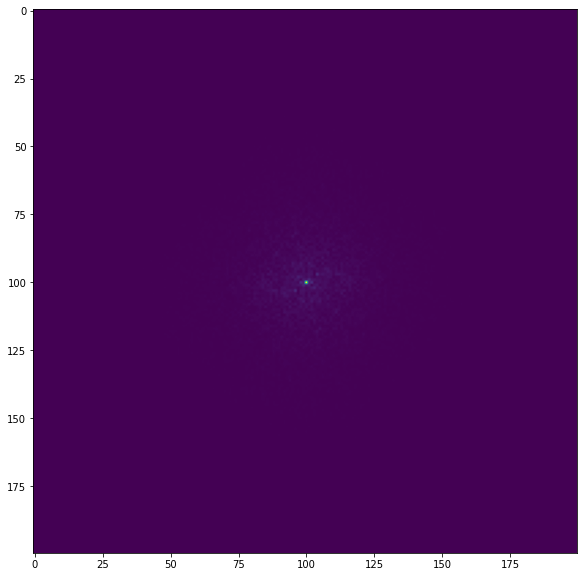

In [ ]:
ShiftFourier_2D = np.fft.fftshift(fourier_2D)
norm_ShiftFourier_2D = np.abs(ShiftFourier_2D)
d_spacing = 0.001
%matplotlib inline
plt.figure(figsize = (12,10))
plt.imshow(np.abs(norm_ShiftFourier_2D))

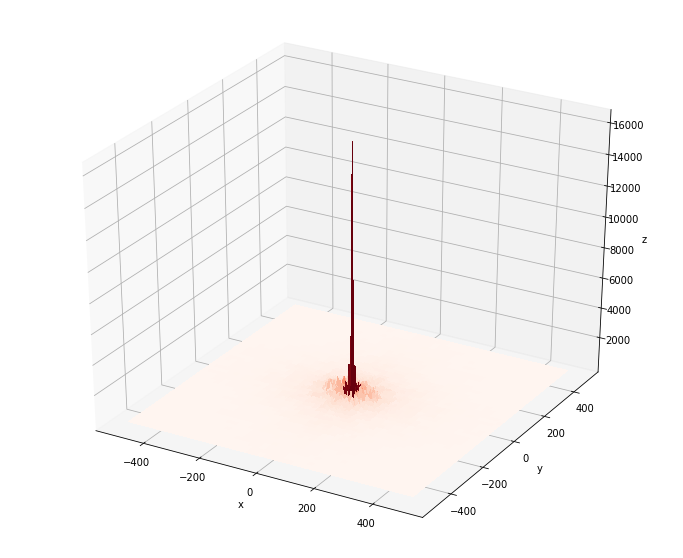

In [ ]:
freqs_x = np.fft.fftfreq(norm_ShiftFourier_2D.shape[0], d=d_spacing)

freqs_y = np.fft.fftfreq(norm_ShiftFourier_2D.shape[1], d=d_spacing)

#print(freqs_x)


freqs_X, freqs_Y = np.meshgrid(sorted(freqs_x), sorted(freqs_y))

fig = plt.figure(figsize = (12,10))

ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, norm_ShiftFourier_2D, 100, cmap='viridis') # Creates 'n=10' contours at different Z to make the surface
surf = ax.plot_surface(freqs_X, freqs_Y, norm_ShiftFourier_2D, cmap = "Reds", linewidth=0, antialiased=False)

ax.set_xlabel('x')  # Customised labels for axes
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

### **TASK 3**


In [ ]:
from scipy import ndimage

In [ ]:
#===================================================================
# Get PSD 1D (total radial power spectrum)
#===================================================================
def GetPSD1D(psd2D):
    h  = psd2D.shape[0]
    w  = psd2D.shape[1]
    wc = w//2
    hc = h//2

    # create an array of integer radial distances from the center
    Y, X = np.ogrid[0:h, 0:w]
    r    = np.hypot(X - wc, Y - hc).astype(int)

    # SUM all psd2D pixels with label 'r' for 0<=r<=wc
    # NOTE: this will miss power contributions in 'corners' r>wc
    psd1D = ndimage.sum(psd2D, r, index=np.arange(0, wc))

    return psd1D
#===================================================================

# Taken from: https://medium.com/tangibit-studios/2d-spectrum-characterization-e288f255cc59

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


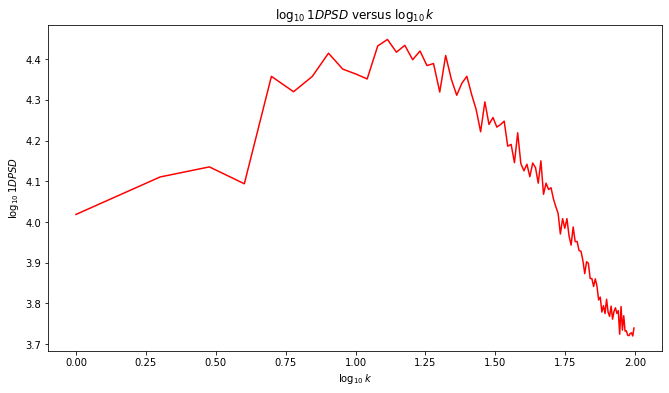

In [ ]:
PSD1D=GetPSD1D(norm_ShiftFourier_2D)
l=PSD1D.shape[0]
wavevector = np.arange(0,l)
x=np.log10(wavevector)
y=np.log10(PSD1D)
#log-log plot
plt.figure(figsize = (11,6))
plt.plot(x, y, c='red')
plt.title(r'$\log_{10}\,1DPSD $ versus $\log_{10}\,k$')
plt.xlabel(r'$\log_{10}\,k$')
plt.ylabel(r'$\log_{10}\,1DPSD$')
plt.show()

### **TASK 4**

In [ ]:
coord = []

for a, b in zip( x, y ):
    coord.append( [ a, b ] )

print( coord )


[[-inf, 4.217133721722958], [0.0, 4.018603068350017], [0.3010299956639812, 4.11066304985515], [0.47712125471966244, 4.135350059385795], [0.6020599913279624, 4.09392217364996], [0.6989700043360189, 4.357740309210048], [0.7781512503836436, 4.319994300723712], [0.8450980400142568, 4.357551784348631], [0.9030899869919435, 4.414621564436474], [0.9542425094393249, 4.375464758023227], [1.0, 4.363790214269239], [1.041392685158225, 4.351381700779556], [1.0791812460476249, 4.432466274580518], [1.1139433523068367, 4.448378559712321], [1.146128035678238, 4.417144055492737], [1.1760912590556813, 4.434006024855709], [1.2041199826559248, 4.398662189758146], [1.2304489213782739, 4.42000153772561], [1.255272505103306, 4.3842787729948745], [1.2787536009528289, 4.38917464798229], [1.3010299956639813, 4.3192561153341105], [1.3222192947339193, 4.409001689718378], [1.3424226808222062, 4.350762109426143], [1.3617278360175928, 4.311375441507947], [1.380211241711606, 4.341005252997322], [1.3979400086720377, 4.

In [ ]:
# np.where(x==1.3424226808222062)
# np.where(x==1.845098040014257)

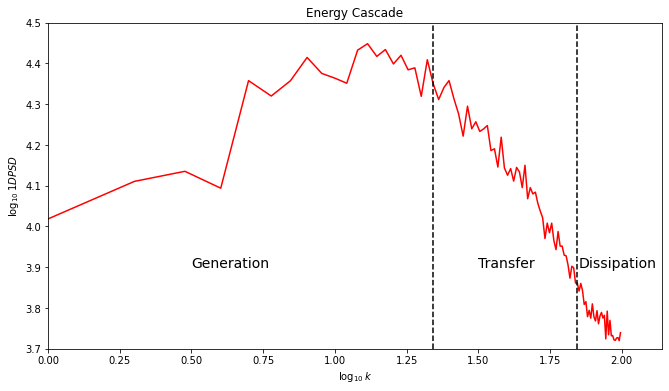

In [ ]:
plt.figure(figsize = (11,6))
plt.plot(x, y, c='red')
plt.plot([1.3424226808222062,1.3424226808222062], [3.7,4.5], '--',color='black')
plt.plot([1.845098040014257,1.845098040014257], [3.7,4.5], '--',color='black')
plt.xlim(0,2.14) 
plt.ylim(3.7,4.5)
plt.text(0.5, 3.9, 'Generation', fontsize=14)
plt.text(1.5, 3.9, 'Transfer', fontsize=14)
plt.text(1.85, 3.9, 'Dissipation', fontsize=14)
plt.title(r'Energy Cascade')
plt.xlabel(r'$\log_{10}\,k$')
plt.ylabel(r'$\log_{10}\,1DPSD$')
plt.show()

In [ ]:
from scipy.optimize import curve_fit
new_x=np.array(x[22:70+1])
new_y=np.array(y[22:70+1])
#index1= 5./3. #Kolmogorov
#index2= 2. #Burgers
def Optimal(new_x,alpha,a):
  return a*(new_x**(-alpha))

def Kolmogorov(new_x,a):
  return a*(new_x**(-3/5))

def Burguers(new_x,a):
  return a*(new_x**(-2))

params, covs=curve_fit(Kolmogorov,new_x, new_y)
params1,covs1=curve_fit(Burguers,new_x, new_y)
params2,covs2=curve_fit(Optimal,new_x, new_y)


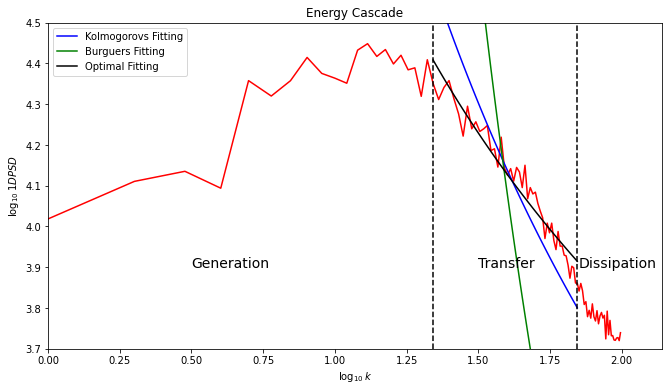

In [ ]:
plt.figure(figsize = (11,6))
plt.plot(x, y, c='red')
plt.plot(new_x, Kolmogorov(new_x, params[0]), 'b',label='Kolmogorovs Fitting')
plt.plot(new_x, Burguers(new_x, params1[0]), 'g',label='Burguers Fitting')
plt.plot(new_x, Optimal(new_x, params2[0], params2[1]), 'black',label='Optimal Fitting')
plt.plot([1.3424226808222062,1.3424226808222062], [3.7,4.5], '--',color='black')
plt.plot([1.845098040014257,1.845098040014257], [3.7,4.5], '--',color='black')
plt.xlim(0,2.14) 
plt.ylim(3.7,4.5)
plt.text(0.5, 3.9, 'Generation', fontsize=14)
plt.text(1.5, 3.9, 'Transfer', fontsize=14)
plt.text(1.85, 3.9, 'Dissipation', fontsize=14)
plt.title(r'Energy Cascade')
plt.xlabel(r'$\log_{10}\,k$')
plt.ylabel(r'$\log_{10}\,1DPSD$')
plt.legend()
plt.show()